# ClusterEnsemble demonstration
Some example usage of how to build up a dataframe of galaxy cluster properties, where each cluster is treated as an individual. This may be useful for fitting a stacked weak lensing profile, for example, where you want to avoid fitting a single average cluster mass and redshift.

In [1]:
from __future__ import absolute_import, division, print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from astropy import units
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()  #this line can be commented out

In [2]:
from clusters import ClusterEnsemble

### Create a ClusterEnsemble object by passing in a numpy array (or list) of redshifts

In [3]:
z = np.array([0.1,0.2,0.3])
c = ClusterEnsemble(z)
c.describe

'Ensemble of galaxy clusters and their properties.'

### Display what we have so far
Below the DataFrame, we see the default assumptions for the power-law slope and normalization that will be used to convert richness $N_{200}$ to mass $M_{200}$. We'll see how to change those parameters below.

In [4]:
c.show()


Cluster Ensemble:


,z
0,0.1
1,0.2
2,0.3



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


### Add richness values to the dataframe
This step will also generate $M_{200}$, $r_{200}$, $c_{200}$, and scale radius $r_s$, assuming the scaling relation given below.

In [5]:
n200 = np.array([20.,20.,20.])
c.update_richness(n200)
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.1,20,2.700000e+13,0.612222,5.821359,12329.828385,0.105168
1,0.2,20,2.700000e+13,0.591082,5.627032,11398.735247,0.105043
2,0.3,20,2.700000e+13,0.569474,5.426060,10482.820471,0.104952



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


### Access any column of the dataframe as an array
Notice that units are present for the appropriate columns.

In [6]:
print('z: \t', c.z)
print('n200: \t', c.n200)
print('r200: \t', c.r200)
print('m200: \t', c.m200)
print('c200: \t', c.c200)
print('rs: \t', c.rs)

z: 	 [ 0.1  0.2  0.3]
n200: 	 [ 20.  20.  20.]
r200: 	 [ 0.61222163  0.59108187  0.56947428] Mpc
m200: 	 [  2.70000000e+13   2.70000000e+13   2.70000000e+13] solMass
c200: 	 [ 5.82135877  5.62703234  5.42605953]
rs: 	 [ 0.10516817  0.10504327  0.10495172] Mpc


###If you don't want units, you can get just the values

In [7]:
c.r200.value

array([ 0.61222163,  0.59108187,  0.56947428])

### Change the redshifts or richness values
These changes will propogate to all redshift-dependant or richness-dependant cluster attributes, as appropriate.

In [8]:
c.update_z(np.array([0.4,0.5,0.6]))
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.4,20,2.700000e+13,0.547827,5.229151,9630.870869,0.104764
1,0.5,20,2.700000e+13,0.526483,5.041283,8859.107775,0.104434
2,0.6,20,2.700000e+13,0.505701,4.864887,8170.244874,0.103949



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


In [9]:
c.update_richness([20,30,40])
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.4,20,2.700000e+13,0.547827,5.229151,9630.870869,0.104764
1,0.5,30,4.763120e+13,0.636151,4.795641,7909.142281,0.132652
2,0.6,40,7.125343e+13,0.698834,4.477974,6777.240275,0.156060



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.4


### Change the parameters in the mass-richness relation
Either or both of the parameters "slope" and "norm" can be passed to the update_massrichrelation() method.

In [10]:
c.update_massrichrelation(slope = 1.5)
c.show()


Cluster Ensemble:


,z,n200,m200,r200,c200,delta_c,rs
0,0.4,20,2.700000e+13,0.547827,5.229151,9630.870869,0.104764
1,0.5,30,4.960217e+13,0.644807,4.778560,7845.536637,0.134938
2,0.6,40,7.636753e+13,0.715169,4.451545,6687.866844,0.160656



Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.5


### Show basic table
Perhaps we don't want the fancy pandas formatting on our table, or maybe we're not working in the Jupyter notebook.

In [11]:
c.show(notebook = False)


Cluster Ensemble:
     z  n200          m200      r200      c200      delta_c        rs
0  0.4    20  2.700000e+13  0.547827  5.229151  9630.870869  0.104764
1  0.5    30  4.960217e+13  0.644807  4.778560  7845.536637  0.134938
2  0.6    40  7.636753e+13  0.715169  4.451545  6687.866844  0.160656

Mass-Richness Power Law: M200 = norm * (N200 / 20) ^ slope
   norm: 2.7e+13 solMass
   slope: 1.5


# Calculate $\Sigma(r)$ and $\Delta\Sigma(r)$ for NFW model
First select the radial bins in units of Mpc.

In [12]:
rmin, rmax = 0.1, 5. #Mpc
nbins = 50
rbins = np.logspace(np.log10(rmin), np.log10(rmax), 
                     num = nbins) * units.Mpc
rbins

<Quantity [ 0.1       , 0.10831107, 0.11731288, 0.12706284, 0.13762313,
            0.14906109, 0.16144966, 0.17486786, 0.18940126, 0.20514253,
            0.22219208, 0.24065862, 0.26065994, 0.28232357, 0.30578769,
            0.33120193, 0.35872836, 0.38854254, 0.42083459, 0.45581046,
            0.4936932 , 0.5347244 , 0.57916573, 0.62730062, 0.67943603,
            0.73590445, 0.79706601, 0.86331074, 0.93506113, 1.01277474,
            1.09694718, 1.18811526, 1.28686038, 1.39381229, 1.50965304,
            1.6351214 , 1.77101753, 1.91820809, 2.07763176, 2.25030524,
            2.43732975, 2.639898  , 2.85930184, 3.0969405 , 3.35432947,
            3.63311024, 3.93506067, 4.26210643, 4.61633319, 5.        ] Mpc>

In [13]:
c.calc_nfw(rbins)

In [14]:
c.sigma_nfw

<Quantity [[  1.39367876e+02,  1.26663035e+02,  1.14815477e+02,
              1.03805742e+02,  9.36101700e+01,  8.42013230e+01,
              7.55484460e+01,  6.76179810e+01,  6.03741370e+01,
              5.37794370e+01,  4.77952470e+01,  4.23823420e+01,
              3.75013710e+01,  3.31133390e+01,  2.91799890e+01,
              2.56641680e+01,  2.25301110e+01,  1.97436760e+01,
              1.72725260e+01,  1.50862520e+01,  1.31564500e+01,
              1.14567540e+01,  9.96283900e+00,  8.65237900e+00,
              7.50499500e+00,  6.50216600e+00,  5.62714400e+00,
              4.86484000e+00,  4.20171900e+00,  3.62567700e+00,
              3.12593500e+00,  2.69291700e+00,  2.31814600e+00,
              1.99413500e+00,  1.71429100e+00,  1.47282000e+00,
              1.26464200e+00,  1.08531500e+00,  9.30957000e-01,
              7.98187000e-01,  6.84060000e-01,  5.86018000e-01,
              5.01843000e-01,  4.29612000e-01,  3.67661000e-01,
              3.14550000e-01,  2.6903800

In [15]:
c.deltasigma_nfw

<Quantity [[ 113.856157, 108.785197, 103.670471,  98.536475,  93.40797 ,
              88.309558,  83.265263,  78.298132,  73.429885,  68.680595,
              64.068409,  59.609364,  55.317217,  51.203383,  47.276886,
              43.544405,  40.010346,  36.676956,  33.544489,  30.611374,
              27.874417,  25.329012,  22.96935 ,  20.788627,  18.77925 ,
              16.933025,  15.241333,  13.695296,  12.285909,  11.004175,
               9.841202,   8.7883  ,   7.837048,   6.979351,   6.207488,
               5.514135,   4.892393,   4.335793,   3.838302,   3.394317,
               2.998658,   2.646551,   2.333617,   2.055848,   1.80959 ,
               1.59152 ,   1.398623,   1.228174,   1.077711,   0.94502 ],
           [ 152.938935, 147.287985, 141.500991, 135.602805, 129.620047,
             123.580694, 117.513602, 111.448016, 105.413086,  99.437363,
              93.548316,  87.771923,  82.132255,  76.651184,  71.348096,
              66.239727,  61.340043,  56.660191,  

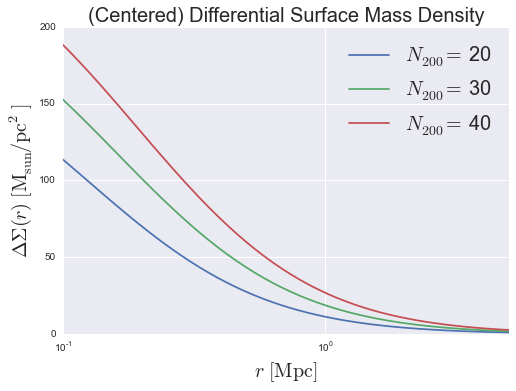

In [21]:
for rich, profile in zip(c.n200,c.deltasigma_nfw):
    plt.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
plt.xscale('log')
plt.legend(fontsize=20)

plt.xlim(rbins.value.min(), rbins.value.max())
plt.xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
plt.ylabel('$\Delta\Sigma(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$', fontsize=20)
plt.title('(Centered) Differential Surface Mass Density', fontsize=20)

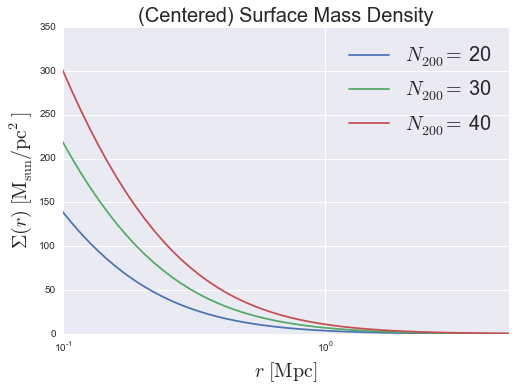

In [22]:
for rich, profile in zip(c.n200,c.sigma_nfw):
    plt.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
plt.xscale('log')
plt.legend(fontsize=20)

plt.xlim(rbins.value.min(), rbins.value.max())
plt.xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
plt.ylabel('$\Sigma(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$', fontsize=20)
plt.title('(Centered) Surface Mass Density', fontsize=20)

# Calculate Miscentered NFW Profiles
First select the offsets in units of Mpc. The offset values parameterize the width of the Gaussian distribution of offsets, and is $\sigma_\mathrm{off}$ in Equation 11 of [Ford et al 2015](http://arxiv.org/abs/1409.3571).

In [24]:
offsets = np.array([0.1,0.1,0.1])
c.calc_nfw(rbins, offsets=offsets)

In [25]:
#c.deltasigma_offset
#c.sigma_offset

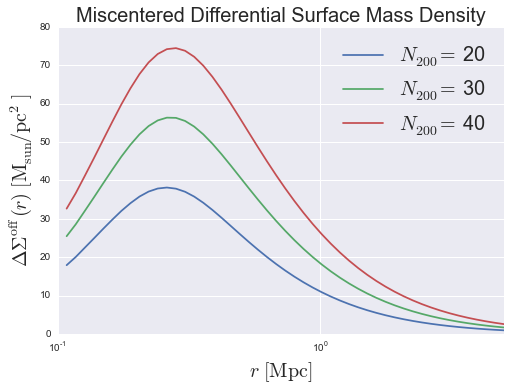

In [26]:
for rich, profile in zip(c.n200,c.deltasigma_offset):
    plt.plot(rbins, profile, label='$N_{200}=$ '+str(rich))
plt.xscale('log')
plt.legend(fontsize=20)

plt.xlim(rbins.value.min(), rbins.value.max())
plt.xlabel('$r\ [\mathrm{Mpc}]$', fontsize=20)
plt.ylabel('$\Delta\Sigma^\mathrm{off}(r)\ [\mathrm{M}_\mathrm{sun}/\mathrm{pc}^2]$', fontsize=20)
plt.title('Miscentered Differential Surface Mass Density', fontsize=20)

### To Do: 
- fix bug giving Inf in first bin of smoothed profiles
- write tests for calc_nfw() and replace smd_nfw.c with cython version
- write more tests